In [1]:
import os

import numpy as np

import torch
import torchvision
from torchvision.io import read_image
from torchvision.transforms import v2

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from piq import BRISQUELoss, TVLoss, brisque, ssim, psnr

import random

import cv2

import matplotlib.pyplot as plt

from utils import loss_history, plot_history

from tqdm import tqdm

import json

import wandb

%matplotlib inline

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
path_img = './data/RealSR(V3)/canon/train/2'

path_hr_img = './data/div2k/DIV2K_train_HR'
path_lr_x2_img = './data/div2k/DIV2K_train_LR_unknown/X2'
patch_size = (128,128)
images_lr = []
images_hr = []
images_lr_patches = []
images_hr_patches = []
scale=2
data_range=1. #255.


for filename in tqdm(os.listdir(path_img)):
    if filename.find('LR')>0:
        img = read_image(os.path.join(path_img, filename))
        transform = torchvision.transforms.Compose([
            v2.ToPureTensor(),
            v2.ToDtype(torch.float)
        ])
        if data_range==1:
            img = transform(img)/255.
        img = torch.clamp(img, 0, data_range)
        images_lr.append(img)
        patches = img.data.unfold(0, 3, 3).unfold(1, patch_size[0], patch_size[1]).unfold(2, patch_size[0], patch_size[1])
        size = patches[0].shape
        for i in range(size[0]):
            for j in range(size[1]):
                images_lr_patches.append(patches[0][i][j])
    else:
        img = read_image(os.path.join(path_img, filename))
        transform = torchvision.transforms.Compose([
            v2.ToPureTensor(),
            v2.ToDtype(torch.float)
        ])
        if data_range==1:
            img = transform(img)/255.
        img = torch.clamp(img, 0, data_range)
        images_hr.append(img)
        patches = img.data.unfold(0, 3, 3).unfold(1, patch_size[0]*scale, patch_size[1]*scale).unfold(2, patch_size[0]*scale, patch_size[1]*scale)
        size = patches[0].shape
        for i in range(size[0]):
            for j in range(size[1]):
                images_hr_patches.append(patches[0][i][j])
        

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.87it/s]


In [4]:
path_img_test = './data/RealSR(V3)/canon/test/2'
patch_size = (128,128)
images_lr_test = []
images_hr_test = []
images_lr_test_patches = []
images_hr_test_patches = []
scale=2
data_range=1. #255.

for filename in tqdm(os.listdir(path_img_test)):
    if filename.find('LR')>0:
        img = read_image(os.path.join(path_img_test, filename))
        transform = torchvision.transforms.Compose([
            v2.ToPureTensor(),
            v2.ToDtype(torch.float)
        ])
        if data_range==1:
            img = transform(img)/255.
        img = torch.clamp(img, 0, data_range)
        images_lr_test.append(img)
        patches = img.data.unfold(0, 3, 3).unfold(1, patch_size[0], patch_size[1]).unfold(2, patch_size[0], patch_size[1])
        size = patches[0].shape
        for i in range(size[0]):
            for j in range(size[1]):
                images_lr_test_patches.append(patches[0][i][j])
    else:
        img = read_image(os.path.join(path_img_test, filename))
        transform = torchvision.transforms.Compose([
            v2.ToPureTensor(),
            v2.ToDtype(torch.float)
        ])
        if data_range==1:
            img = transform(img)/255.
        img = torch.clamp(img, 0, data_range)
        images_hr_test.append(img)
        patches = img.data.unfold(0, 3, 3).unfold(1, patch_size[0]*scale, patch_size[1]*scale).unfold(2, patch_size[0]*scale, patch_size[1]*scale)
        size = patches[0].shape
        for i in range(size[0]):
            for j in range(size[1]):
                images_hr_test_patches.append(patches[0][i][j])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.87it/s]


In [5]:
images_hr_fathers = []
images_lr_sons = []
scales = [2, 3, 4] #, 5, 6, 7, 8, 9]
scale_son=2

for image in tqdm(images_lr):
    for scale in scales:    
        resizes = {
            'bilinear': torchvision.transforms.Resize((int(image.shape[1]/scale), int(image.shape[2]/scale)),
                                                     interpolation=torchvision.transforms.InterpolationMode.BILINEAR,
                                                     antialias=True),
            'nearest': torchvision.transforms.Resize((int(image.shape[1]/scale), int(image.shape[2]/scale)),
                                                     interpolation=torchvision.transforms.InterpolationMode.NEAREST,
                                                     antialias=True),
            'nearest_exact': torchvision.transforms.Resize((int(image.shape[1]/scale), int(image.shape[2]/scale)),
                                                     interpolation=torchvision.transforms.InterpolationMode.NEAREST_EXACT,
                                                     antialias=True),
            'bicubic': torchvision.transforms.Resize((int(image.shape[1]/scale), int(image.shape[2]/scale)),
                                                     interpolation=torchvision.transforms.InterpolationMode.BICUBIC,
                                                     antialias=True),  
        }
        resize_as = random.choice(list(resizes.values()))
        image_downscale = resize_as(image)
        if image_downscale.shape[1] % 2 != 0 or image_downscale.shape[2] %2 != 0:
            new_h = image_downscale.shape[1] - 1 if image_downscale.shape[1] % 2 != 0 else image_downscale.shape[1]
            new_w = image_downscale.shape[2] - 1 if image_downscale.shape[2] % 2 != 0 else image_downscale.shape[2]
            crop = torchvision.transforms.CenterCrop((new_h, new_w))
            image_downscale = crop(image_downscale)
            
        augmenters = {
            #'Rotate90': torchvision.transforms.RandomRotation(degrees=(90,90), expand=True),
            #'Rotate180': torchvision.transforms.RandomRotation(degrees=(180,180), expand=True),
            #'Rotate270': torchvision.transforms.RandomRotation(degrees=(270,270), expand=True),
            'HFlip': torchvision.transforms.RandomHorizontalFlip(p=1),
            'VFlip': torchvision.transforms.RandomVerticalFlip(p=1),
        }
        for (augmenter_name, augmenter) in augmenters.items():
            resizes_son = {
                'bilinear': torchvision.transforms.Resize((int(image_downscale.shape[1]/scale_son),
                                                           int(image_downscale.shape[2]/scale_son)),
                                                         interpolation=torchvision.transforms.InterpolationMode.BILINEAR,
                                                         antialias=True),
                'nearest': torchvision.transforms.Resize((int(image_downscale.shape[1]/scale_son),
                                                          int(image_downscale.shape[2]/scale_son)),
                                                         interpolation=torchvision.transforms.InterpolationMode.NEAREST,
                                                         antialias=True),
                'nearest_exact': torchvision.transforms.Resize((int(image_downscale.shape[1]/scale_son),
                                                                int(image_downscale.shape[2]/scale_son)),
                                                         interpolation=torchvision.transforms.InterpolationMode.NEAREST_EXACT,
                                                         antialias=True),
                'bicubic': torchvision.transforms.Resize((int(image_downscale.shape[1]/scale_son),
                                                          int(image_downscale.shape[2]/scale_son)),
                                                         interpolation=torchvision.transforms.InterpolationMode.BICUBIC,
                                                         antialias=True),  
            }
            resize_as = random.choice(list(resizes_son.values()))
            image_downscale_son = resize_as(image_downscale)
            img_aug_father = augmenter(image_downscale)
            img_aug_son = augmenter(image_downscale_son)
            images_hr_fathers.append(img_aug_father)
            images_lr_sons.append(img_aug_son)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 26.28it/s]


1200
torch.Size([3, 200, 350]) torch.Size([3, 100, 175])


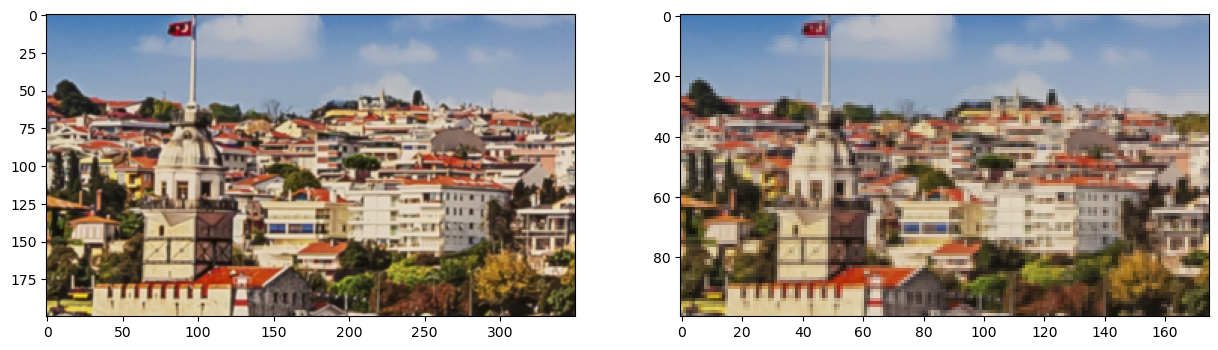

In [6]:
print(len(images_hr_fathers))
n=6
plt.subplots(1,2, figsize=(15, 15))
plt.subplot(1,2,1)
plt.imshow(images_hr_fathers[n].permute(1,2,0)) #.type(torch.LongTensor))
plt.subplot(1,2,2)
plt.imshow(images_lr_sons[n].permute(1,2,0)) #.type(torch.LongTensor))
print(images_hr_fathers[n].shape, images_lr_sons[n].shape)

In [7]:
class images_dataset(Dataset):
    def __init__(self, data_source, data_target):
        self.data_source = data_source
        self.data_target = data_target
        
    def __len__(self):
        return len(self.data_source)
    
    def __getitem__(self, index):
        data_source = self.data_source[index]
        data_target = self.data_target[index]
        return data_source, data_target

In [8]:
def collate_fn(batch):
    data_source = torch.LongTensor([item[0] for item in batch])
    data_target = torch.LongTensor([item[1] for item in batch])
    return data_source, data_target

In [37]:
class conv_block(nn.Module):
    def __init__(self, *args, **kwargs):
        super(conv_block, self).__init__()
        self.conv1 = nn.Conv2d(*args, **kwargs)
        #self.bn = nn.BatchNorm2d(kwargs['out_channels'])
        self.activation1 = nn.ReLU()
        self.conv2 = nn.Conv2d(*args, **kwargs)
        self.activation2 = nn.ReLU()
        
    def forward(self, x):
        x_input = x
        x = self.conv1(x_input)
        #x = self.bn(x)
        x = self.activation1(x)
        x = self.conv2(x)
        #x = self.bn(x)
        x = self.activation2(x)        
        return x + x_input
        

class lrdown2lr(nn.Module):
    def __init__(self, scale=2, n_blocks=8, channels=64, max_value=1.):
        super().__init__()
        
        self.n_blocks = n_blocks
        self.channels = channels
        self.max_value = max_value
        
        #self.upscale = nn.Upsample(scale_factor=2)
        self.upscale = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3*scale*scale, kernel_size=(1,1), stride=1, padding='same'),
            nn.PixelShuffle(upscale_factor=scale)
        )
        
        #self.conv = nn.Sequential(
        #    nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3), stride=1, padding='same'),
        #    nn.GELU(),
        #    nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(5,5), stride=1, padding='same'),
        #    nn.GELU()
        #)
        #self.conv_resc1 = nn.Sequential(
        #    nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), padding='same'),
        #    nn.GELU()
        #)
        
        
        
        self.conv_in = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=channels, kernel_size=3, padding='same'),
            nn.ReLU()
        )
        self.conv_inner_blocks = nn.ModuleList(conv_block(in_channels=channels,
                                     out_channels=channels,
                                     kernel_size=3,
                                     padding='same') for n in range(n_blocks))
        
        self.conv_out = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=3, kernel_size=3, padding='same'),
            nn.ReLU()
        )

    
    def forward(self, x):
        x = self.upscale(x)
        #x = self.conv(x) + self.conv_resc1(x)
        x = self.conv_in(x)
        for conv_inner in self.conv_inner_blocks:
            x = conv_inner(x)
        x = self.conv_out(x)
        x = torch.clamp(x, min=0., max=self.max_value)
        return x


In [43]:
class conv_block(nn.Module):
    def __init__(self, *args, **kwargs):
        super(conv_block, self).__init__()
        self.conv = nn.Conv2d(*args, **kwargs)
        self.activation = nn.GELU()
        
    def forward(self, x):
        x_input = x
        x = self.conv(x_input)
        x = self.activation(x)
        return x # + x_input
        

class zssr(nn.Module):
    def __init__(self, scale=2, n_blocks=8, channels=64, max_value=1.):
        super().__init__()
        
        self.n_blocks = n_blocks
        self.channels = channels
        self.max_value = max_value
        

        self.upscale = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3*scale*scale, kernel_size=(1,1), stride=1, padding='same'),
            nn.PixelShuffle(upscale_factor=scale)
        )
        
        self.conv_in = nn.Conv2d(in_channels=3, out_channels=channels, kernel_size=(1,1), stride=1, padding='same')
        
       
        self.conv_inner_blocks = nn.ModuleList(conv_block(in_channels=channels,
                                     out_channels=channels,
                                     kernel_size=3,
                                     padding='same') for n in range(n_blocks))
        
        self.conv_out = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=3, kernel_size=3, padding='same'),
            nn.GELU()
        )

    
    def forward(self, x):
        x0 = self.upscale(x)
        x = self.conv_in(x0)
        for conv_inner in self.conv_inner_blocks:
            x = conv_inner(x)
        x = self.conv_out(x)
        out = torch.add(x, x0)
        out = torch.clamp(out, min=0., max=self.max_value)
 
        return out

In [11]:
class torch_trainer():
    
    def __init__(self, model, criterion, optimizer, epochs, dataloader, device='cuda', scheduler=None):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.dataloader = dataloader
        self.device = device
        self.history = train_history()
        self.metrics = None
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model.to(device)
        self.wandb_log()
    
        
    def train(self):

        self.history.clear()
        loss = 0
        val_loss = 0

        for epoch in range(self.epochs):

            epoch_loss = []
            epoch_val_loss = []
            epoch_metrics = []
            items = len(self.dataloader['train'])

            self.model.train()
            item=1
            for batch in self.dataloader['train']:
                self.optimizer.zero_grad()
                data = batch[0].to(device)
                preds = self.model(data)
                del data
                target = batch[1].to(device)
                loss = self.criterion(preds, target)
                loss.backward()
                del target
                del preds
                epoch_loss.append(loss.numpy(force=True))
                self.optimizer.step()
                self.print_log(epoch_log=False, epoch=epoch, item=item, items=items, train_loss=loss)        
                item+=1

            items = len(self.dataloader['test'])
            self.model.eval()
            item=1
            with torch.no_grad():
                for batch in self.dataloader['test']:
                    data = batch[0].to(device)
                    preds = self.model(data)
                    del data
                    target = batch[1].to(device)
                    val_loss = self.criterion(preds, target)
                    if self.metrics:
                        metric = self.metrics(preds, target)
                        epoch_metrics.append(metric.numpy(force=True))
                    del target
                    del preds
                    epoch_val_loss.append(val_loss.numpy(force=True))
                    self.print_log(epoch_log=False, epoch=epoch, item=item, items=items, train_loss=loss, val_loss=val_loss) 
                    item+=1                  
                    
            loss = np.array(epoch_loss).mean()
            val_loss = np.array(epoch_val_loss).mean()
            metric = np.array(epoch_metrics).mean()

            if scheduler:
                scheduler.step(loss) 
                        
            
            self.history.loss.append(loss)
            self.history.val_loss.append(val_loss)
            self.history.metric.append(metric)
            
            self.print_log(epoch_log=True, epoch=epoch, item=item, items=items, train_loss=loss, val_loss=val_loss, metric=metric) 
            

        return self.history
    
    def set_metrics(self, metric_name, metric_function):
        self.metric_name = metric_name
        self.metrics = metric_function
    
    def print_log(self, epoch_log = True, epoch=0, item=0, items=0, train_loss=0, val_loss=0, metric=0):
        lr = self.optimizer.param_groups[0]["lr"]
        log = {'epoch': str(epoch+1) + '/' + str(self.epochs),
               'train/loss': train_loss,
               'val/loss': val_loss}
        if epoch_log:
            log['lr'] = lr
            if self.metrics:
                metric_key = f'metric/{self.metric_name}'
                log[metric_key] = metric
        
        if epoch_log:
            log_str = f'epoch {epoch+1}/{self.epochs}... '
        else:
            log_str = f'epoch {epoch+1}/{self.epochs}... batch {item}/{items} '

        for item in [item for item in log if item!='epoch' and item!='item']:
            if torch.is_tensor(log[item]):
                value = log[item].item()
                value = f'{value:.4f}'
            else:
                if type(log[item])==np.float32:
                    value = f'{log[item]:.4f}'
                else:
                    value = log[item]
            log_str = log_str + ' ' + item + ': ' + str(value)

        if epoch_log:
            print(log_str, end='\n')
        else:
            print(log_str, end='\r')
            
        if self.wandb and epoch_log:
            wandb.log(log, step=epoch)
    
    def wandb_log(self, wandb=False):
        self.wandb=wandb

class train_history():
    loss = []
    val_loss = []
    metric = []
    
    def init(self):
        self.loss = []
        self.val_loss = []
        self.metric = []
        
    def clear(self):
        self.loss.clear()
        self.val_loss.clear()
        self.metric.clear()
    
    def plot(self, train=True, val=True, metric=None):
        if train:
            plt.plot(self.loss, label='train loss')
        if val:
            plt.plot(self.val_loss, label='val loss')
        if metric:
            plt.plot(self.metric, label=metric)
        plt.legend()
        plt.show()  

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print (device) 

cuda


In [13]:
wandb.login()

wandb: Currently logged in as: lavrentyevvu. Use `wandb login --relogin` to force relogin


True

In [14]:
ds_lr_downscaled = images_dataset(images_lr_sons, images_hr_fathers)
ds_lr_downscaled_train, ds_lr_downscaled_test = torch.utils.data.random_split(ds_lr_downscaled, [0.8, 0.2])

BATCH_SIZE = 1

dl_lrdown2lr_train = DataLoader(ds_lr_downscaled_train,
                               batch_size=BATCH_SIZE,
                               shuffle=True)
dl_lrdown2lr_test = DataLoader(ds_lr_downscaled_test,
                               batch_size=BATCH_SIZE,
                               shuffle=True)

dl_lrdown2lr = {'train': dl_lrdown2lr_train, 'test': dl_lrdown2lr_test}

In [15]:
def loss_tv(y_pred, y_true):
    loss = TVLoss()(y_pred)
    loss = 1000/loss + 0.01*nn.SmoothL1Loss()(y_pred, y_true)
    return loss

In [16]:
def fft_loss(y_pred, y_true):
    loss = torch.sum(torch.abs(torch.fft.rfft(y_pred, 1)))
    loss = 100/loss + 10*nn.SmoothL1Loss()(y_pred, y_true)
    return loss    

In [17]:
def loss_ssim_l2(y_pred, y_true):
    data_range = 1.
    y_true = torch.clamp(y_true,0,data_range)
    loss_ssim = 1. - ssim(y_pred, y_true, data_range=data_range)
    loss_l2 = nn.MSELoss()(y_pred, y_true)
    del y_true
    del y_pred
    return loss_ssim + loss_l2

In [18]:
def metric_ssim(y_pred, y_true):
    data_range=1.
    y_true = torch.clamp(y_true,0,data_range)    
    return ssim(y_pred, y_true, data_range=data_range)

In [45]:
torch.cuda.empty_cache()
model = lrdown2lr(n_blocks=9, channels=128, max_value=1.).to(device)
print(model)
criterion = loss_ssim_l2
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=3,min_lr=1e-10)
trainer = torch_trainer(model=model,
                       criterion=criterion,
                       optimizer=optimizer,
                       epochs=50,
                       dataloader=dl_lrdown2lr)
trainer.set_metrics(metric_name='SSIM', metric_function=metric_ssim)
trainer.wandb_log(True)

run = wandb.init(project='itmo blind superresolution', 
                 group='v2_realsr_zssr', 
                 job_type='train')
wandb.watch(model, criterion, log="all", log_freq=10)

history = trainer.train()

lrdown2lr(
  (upscale): Sequential(
    (0): Conv2d(3, 12, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (1): PixelShuffle(upscale_factor=2)
  )
  (conv_in): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (conv_inner_blocks): ModuleList(
    (0-8): 9 x conv_block(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (activation): GELU(approximate='none')
    )
  )
  (conv_out): Sequential(
    (0): Conv2d(128, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
  )
)


OutOfMemoryError: CUDA out of memory. Tried to allocate 184.00 MiB. GPU 0 has a total capacty of 12.00 GiB of which 0 bytes is free. Of the allocated memory 9.05 GiB is allocated by PyTorch, and 2.10 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

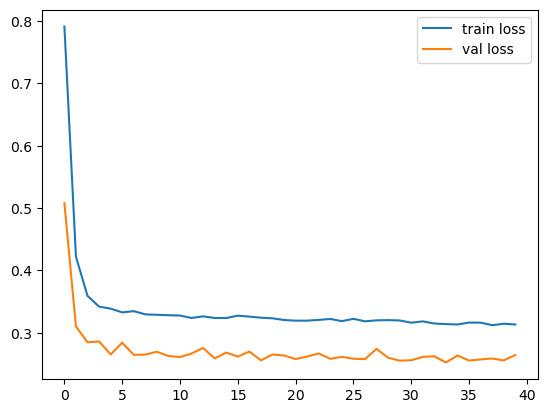

In [20]:
plot_history(history)

In [18]:
def plot_history(history):
    plt.plot(history.loss, label='train loss')
    plt.plot(history.val_loss, label='val loss')
    plt.legend()
    plt.show()

In [92]:
ref.min()

tensor(0.)

tensor(0.8704)


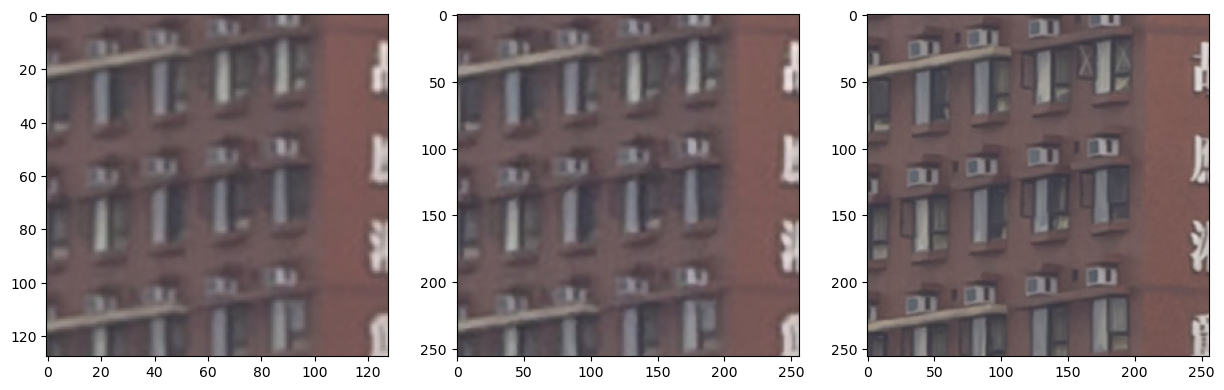

In [29]:
n = 449
ref = images_hr_test_patches[n]

#model = model.to('cpu')
test = images_lr_test_patches[n].to(device)
test = test[None, :]
model.eval()
with torch.no_grad():
    preds = model(test)
img = preds[0].permute(1,2,0).to('cpu')
torchvision.utils.save_image(preds[0], 'div2k_out.png')

plt.subplots(1,3, figsize=(15, 15))
plt.subplot(1,3,1)
plt.imshow(images_lr_test_patches[n].permute(1,2,0)) #.type(torch.LongTensor))
plt.subplot(1,3,2)
plt.imshow(img) #.type(torch.LongTensor))
plt.subplot(1,3,3)
plt.imshow(ref.permute(1,2,0)) #.type(torch.LongTensor))

ssim_after = ssim(preds.to('cpu'), ref[None,:], data_range=1)
print(ssim_after)

tensor(0.9695)


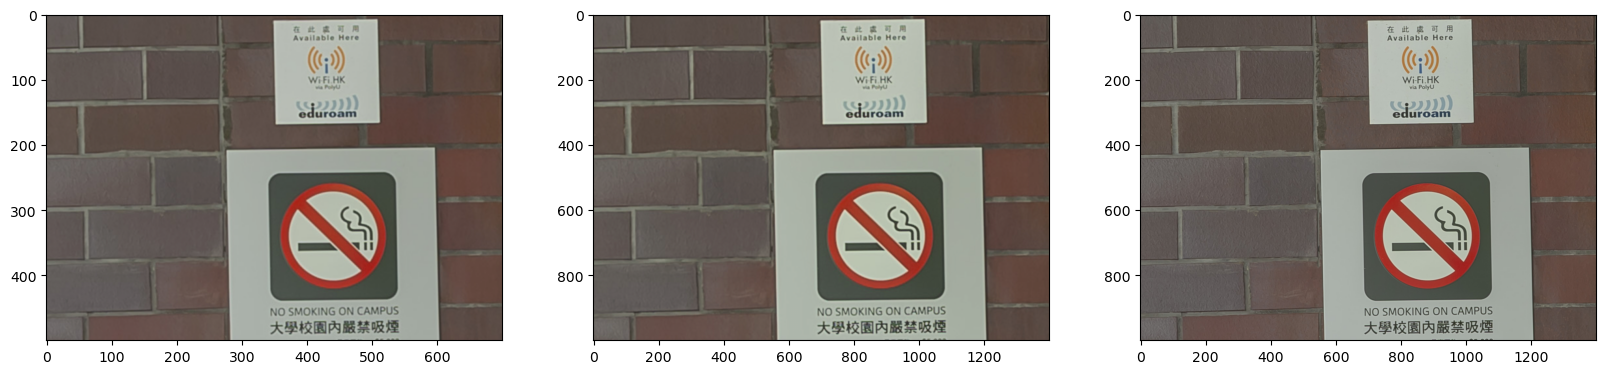

In [36]:
n = 0
ref = images_hr_test[n]

#model = model.to('cpu')
test = images_lr_test[n].to(device)
test = test[None, :]
model.eval()
with torch.no_grad():
    preds = model(test)
img = preds[0].permute(1,2,0).to('cpu')
torchvision.utils.save_image(preds[0], 'realsr_out.png')

plt.subplots(1,3, figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(images_lr_test[n].permute(1,2,0)) #.type(torch.LongTensor))
plt.subplot(1,3,2)
plt.imshow(img) #.type(torch.LongTensor))
plt.subplot(1,3,3)
plt.imshow(ref.permute(1,2,0)) #.type(torch.LongTensor))

ssim_after = ssim(preds.to('cpu'), ref[None,:], data_range=1)
print(ssim_after)

In [34]:
img = cv2.imread('./data/RealSR(V3)/canon/train/2/Canon_001_LR2.png', cv2.IMREAD_UNCHANGED)

print('Original Dimensions : ',img.shape)
 
scale = 2
width = int(img.shape[1] * scale)
height = int(img.shape[0] * scale)
dim = (width, height)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
cv2.imwrite('realsr_tr_01_opencv.png', resized) 
print('Resized Dimensions : ',resized.shape)

cv2.destroyAllWindows()

Original Dimensions :  (400, 700, 3)
Resized Dimensions :  (800, 1400, 3)


In [32]:
img_opencv = read_image('realsr_01_opencv.png')
img_opencv = img_opencv/255.
ssim_after = ssim(img_opencv[None,:], ref[None,:], data_range=1)
print(ssim_after)

tensor(0.9721)


In [72]:
for i in range(len(images_lr)):
    test = images_lr_test[i].to(device)
    ref = images_hr_test[i]
    test = test[None, :]
    model.eval()
    with torch.no_grad():
        preds = model(test)
        img = preds[0].permute(1,2,0).to('cpu')
        ssim_after = ssim(preds.to('cpu'), ref[None,:], data_range=1)
        print(i, '-', ssim_after)

0 - tensor(0.9695)
1 - tensor(0.9710)
2 - tensor(0.8189)
3 - tensor(0.8561)
4 - tensor(0.9518)
5 - tensor(0.9620)
6 - tensor(0.9441)
7 - tensor(0.9410)
8 - tensor(0.9672)
9 - tensor(0.9649)
10 - tensor(0.9696)
11 - tensor(0.9605)
12 - tensor(0.9547)
13 - tensor(0.9432)
14 - tensor(0.9198)
15 - tensor(0.9409)
16 - tensor(0.9503)
17 - tensor(0.9580)
18 - tensor(0.9710)
19 - tensor(0.9612)
20 - tensor(0.9621)
21 - tensor(0.9638)
22 - tensor(0.9622)
23 - tensor(0.9613)
24 - tensor(0.9651)
25 - tensor(0.9221)
26 - tensor(0.9292)
27 - tensor(0.9543)
28 - tensor(0.9607)
29 - tensor(0.9606)
30 - tensor(0.9571)
31 - tensor(0.9439)
32 - tensor(0.9478)
33 - tensor(0.9512)
34 - tensor(0.9481)
35 - tensor(0.9513)
36 - tensor(0.9271)
37 - tensor(0.9825)
38 - tensor(0.9508)
39 - tensor(0.9105)
40 - tensor(0.9618)
41 - tensor(0.9675)
42 - tensor(0.9727)
43 - tensor(0.9767)
44 - tensor(0.9767)
45 - tensor(0.9887)
46 - tensor(0.9707)
47 - tensor(0.9793)
48 - tensor(0.9798)
49 - tensor(0.9715)


IndexError: list index out of range

In [66]:
torch.save(model, './saved/v2_zssrlike_09525')

model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('./saved/v2_zssrlike_09525.pt')

In [35]:
# Model class must be defined somewhere
#model = lrdown2lr(n_blocks=8, channels=128, max_value=1.).to(device)
#model = torch.load('./saved/v2_zssrlike_09525')
#model.eval()

model = torch.jit.load('./saved/v2_zssrlike_09513.pt')
#model.eval()

In [42]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [139]:
ref

tensor([[[0.9255, 0.9255, 0.9294,  ..., 0.2510, 0.2471, 0.2471],
         [0.9255, 0.9255, 0.9294,  ..., 0.2431, 0.2392, 0.2392],
         [0.9294, 0.9294, 0.9294,  ..., 0.2392, 0.2392, 0.2392],
         ...,
         [0.2902, 0.3490, 0.3922,  ..., 0.2706, 0.2627, 0.2588],
         [0.2902, 0.3569, 0.3961,  ..., 0.2353, 0.2431, 0.2510],
         [0.2941, 0.3608, 0.4000,  ..., 0.2196, 0.2235, 0.2353]],

        [[0.9176, 0.9176, 0.9216,  ..., 0.2392, 0.2353, 0.2353],
         [0.9176, 0.9176, 0.9216,  ..., 0.2314, 0.2275, 0.2275],
         [0.9216, 0.9216, 0.9216,  ..., 0.2275, 0.2275, 0.2275],
         ...,
         [0.2863, 0.3412, 0.3765,  ..., 0.2627, 0.2510, 0.2471],
         [0.2863, 0.3490, 0.3804,  ..., 0.2275, 0.2353, 0.2431],
         [0.2902, 0.3529, 0.3843,  ..., 0.2118, 0.2157, 0.2275]],

        [[0.9294, 0.9294, 0.9333,  ..., 0.2745, 0.2706, 0.2706],
         [0.9294, 0.9294, 0.9333,  ..., 0.2667, 0.2627, 0.2627],
         [0.9333, 0.9333, 0.9333,  ..., 0.2706, 0.2706, 0.

# deblur

In [94]:
class nn_deblur(nn.Module):
    def __init__(self, n_channels, max_value=1.):
        self.max_value = max_value
        super(nn_deblur, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=(3,3), stride=1, padding='same'),
            nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(5,5), stride=1, padding='same'),
            #nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(7,7), stride=1, padding='same'),
            #nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(11,11), stride=1, padding='same')
            #nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(1,1), stride=1, padding='same')
        )
        self.conv_resc1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), padding='same')

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=(3,3), stride=1, padding='same'),
            nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(5,5), stride=1, padding='same'),
            #nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(7,7), stride=1, padding='same'),
            #nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(11,11), stride=1, padding='same')
            #nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(1,1), stride=1, padding='same')
        )
        self.conv_resc2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), padding='same')
        
        #self.conv2 = nn.Sequential(
        #    nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=(3,3), stride=1, padding='same'),
        #    nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=(5,5), stride=1, padding='same'),
        #    nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(7,7), stride=1, padding='same'),
            #nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(11,11), stride=1, padding='same')
        #)
        #self.conv_resc2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), padding='same')
        
        self.act = nn.GELU()
        
    def _init_weights(self):
        for m in self.modules():
            #print(m)
            if isinstance(m, nn.Conv2d):           
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0.0)
        
    def forward(self, x):
        x = x.type(torch.cuda.FloatTensor)
        x = self.conv1(x) + self.conv_resc1(x)
        x = self.conv2(x) + self.conv_resc2(x)
        #x = self.conv2(x) + self.conv_resc2(x)
        x = self.act(x)
        x = torch.clamp(x, min=0, max=self.max_value)
        return x

In [95]:
train_data = (images_lr_test[n])[None,:]
#train_data = train_data*255.

ds_deblur_train = images_dataset(train_data, train_data)
#ds_deblur_test = images_dataset(preds*255., (ref*255.)[None,:])
ds_deblur_test = images_dataset(preds, ref[None,:])

BATCH_SIZE = 1

dl_deblur_train = DataLoader(ds_deblur_train,
                               batch_size=BATCH_SIZE,
                               shuffle=False)
dl_deblur_test = DataLoader(ds_deblur_test,
                               batch_size=BATCH_SIZE,
                               shuffle=False)

dl_deblur = {'train': dl_deblur_train, 'test': dl_deblur_test}

In [89]:
ref.shape, preds.shape

(torch.Size([3, 800, 800]), torch.Size([1, 3, 800, 800]))

In [101]:
def metric_ssim(y_pred, y_true):
    #data_range=255.
    data_range=1.
    y_true = torch.clamp(y_true,0,data_range)    
    return ssim(y_pred, y_true, data_range=data_range)

def loss_tv(y_pred, y_true):
    loss_tv_ = TVLoss()(y_pred)
    loss_l1_ = nn.L1Loss()(y_pred, y_true)
    #if loss_l1_ < 10:
    #    loss_l1_ = 0.
    loss = 1000/loss_tv_ + 0.01*loss_l1_
    return loss

model_deblur = nn_deblur(128, max_value=1.)
model_deblur._init_weights()
model_deblur = model_deblur.to(device)
print (model_deblur)
criterion = loss_tv
optimizer = torch.optim.Adam(model_deblur.parameters(), lr=1e-4)          
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=3,min_lr=1e-10)            
trainer = torch_trainer(model=model_deblur,
                                   criterion=criterion,
                                   optimizer=optimizer,
                                   epochs=5000,
                                   dataloader=dl_deblur,
                                   metrics=metric_ssim)
history = trainer.train()


nn_deblur(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(128, 3, kernel_size=(5, 5), stride=(1, 1), padding=same)
  )
  (conv_resc1): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (conv2): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(128, 3, kernel_size=(5, 5), stride=(1, 1), padding=same)
  )
  (conv_resc2): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (act): GELU(approximate='none')
)
epoch 1/5000; train loss: 19.0412, val_loss: 14.8565; lr=0.0001; metric=0.3154
epoch 2/5000; train loss: 16.5113, val_loss: 14.0061; lr=0.0001; metric=0.2984
epoch 3/5000; train loss: 15.8010, val_loss: 13.8415; lr=0.0001; metric=0.2753
epoch 4/5000; train loss: 15.7624, val_loss: 13.8200; lr=0.0001; metric=0.2676
epoch 5/5000; train loss: 15.8281, val_loss: 13.4966; lr=0.0001; metric=0.2667
epoch 6/5000; train loss: 15.4690, val_loss: 12.9606; lr

epoch 100/5000; train loss: 6.0888, val_loss: 5.3036; lr=5e-05; metric=0.2456
epoch 101/5000; train loss: 6.0771, val_loss: 5.2925; lr=5e-05; metric=0.2453
epoch 102/5000; train loss: 6.0653, val_loss: 5.2818; lr=5e-05; metric=0.2450
epoch 103/5000; train loss: 6.0539, val_loss: 5.2711; lr=5e-05; metric=0.2447
epoch 104/5000; train loss: 6.0425, val_loss: 5.2605; lr=5e-05; metric=0.2444
epoch 105/5000; train loss: 6.0312, val_loss: 5.2503; lr=5e-05; metric=0.2441
epoch 106/5000; train loss: 6.0201, val_loss: 5.2401; lr=5e-05; metric=0.2437
epoch 107/5000; train loss: 6.0090, val_loss: 5.2302; lr=5e-05; metric=0.2433
epoch 108/5000; train loss: 5.9979, val_loss: 5.2205; lr=5e-05; metric=0.2428
epoch 109/5000; train loss: 5.9868, val_loss: 5.2107; lr=5e-05; metric=0.2423
epoch 110/5000; train loss: 5.9757, val_loss: 5.2014; lr=5e-05; metric=0.2419
epoch 111/5000; train loss: 5.9648, val_loss: 5.1921; lr=5e-05; metric=0.2413
epoch 112/5000; train loss: 5.9539, val_loss: 5.1829; lr=5e-05; 

KeyboardInterrupt: 

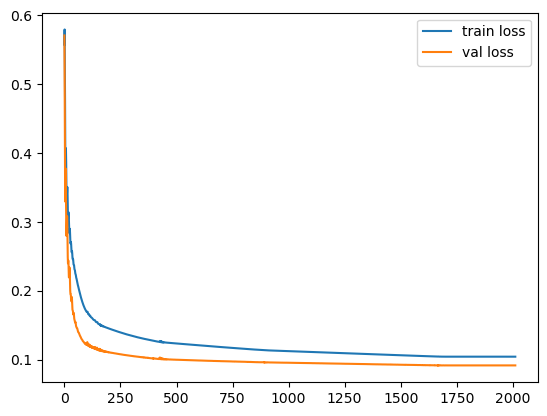

In [79]:
plot_history(history)

tensor(1.0000)


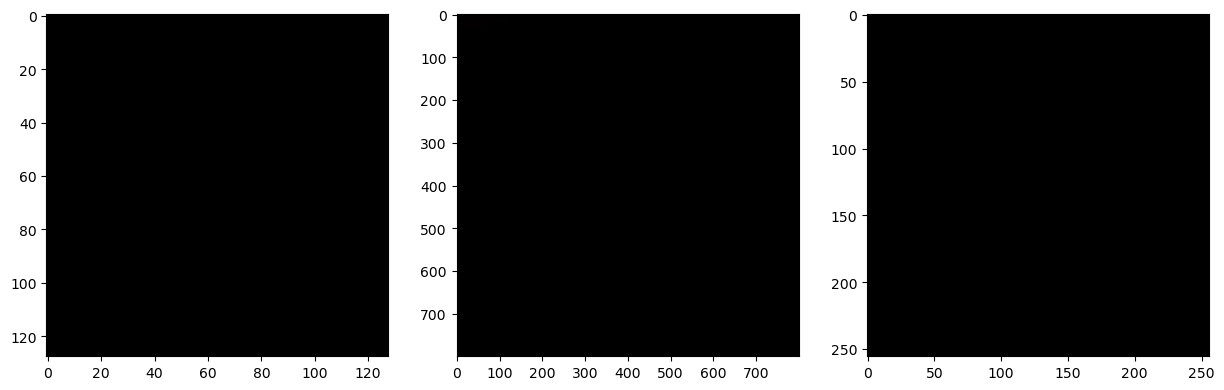

In [80]:
#test = (images_lr_patches[0])[None,:]
test = preds
model_deblur.eval()
with torch.no_grad():
    preds_hr = model_deblur(test)
img = preds_hr[0].permute(1,2,0).detach().cpu()
to_save = (preds_hr[0])/255
#torchvision.utils.save_image(to_save, 'out_div2k_hr.png')
#plt.imshow(img.type(torch.LongTensor))


plt.subplots(1,3, figsize=(15, 15))
plt.subplot(1,3,1)
plt.imshow(images_lr_patches[n].permute(1,2,0).type(torch.LongTensor))
plt.subplot(1,3,2)
plt.imshow(img.type(torch.LongTensor))
plt.subplot(1,3,3)
plt.imshow(images_hr_patches[n].permute(1,2,0).type(torch.LongTensor))

ssim_after = ssim(preds.to('cpu'), ref[None,:], data_range=255)
print(ssim_after)


tensor(0.9474)


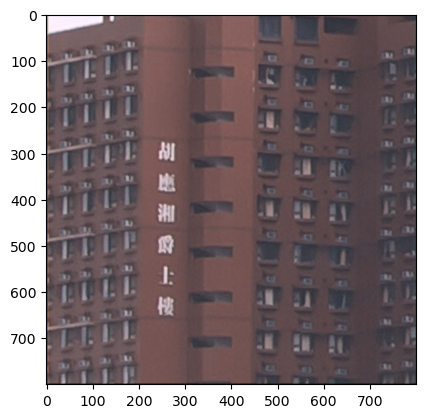

In [85]:
test = preds*255
model_deblur.eval()
with torch.no_grad():
    preds_hr = model_deblur(test)
img = preds_hr[0].permute(1,2,0).detach().cpu()
to_save = (preds_hr[0]).detach().cpu()
to_save = to_save/255.
torchvision.utils.save_image(to_save, 'realsr_deblur_out.png')
plt.imshow(img.type(torch.LongTensor))

ssim_after = ssim(preds_hr.to('cpu'), (ref[None,:])*255, data_range=255)
print(ssim_after)

In [84]:
ref

tensor([[[0.9255, 0.9255, 0.9294,  ..., 0.2510, 0.2471, 0.2471],
         [0.9255, 0.9255, 0.9294,  ..., 0.2431, 0.2392, 0.2392],
         [0.9294, 0.9294, 0.9294,  ..., 0.2392, 0.2392, 0.2392],
         ...,
         [0.2902, 0.3490, 0.3922,  ..., 0.2706, 0.2627, 0.2588],
         [0.2902, 0.3569, 0.3961,  ..., 0.2353, 0.2431, 0.2510],
         [0.2941, 0.3608, 0.4000,  ..., 0.2196, 0.2235, 0.2353]],

        [[0.9176, 0.9176, 0.9216,  ..., 0.2392, 0.2353, 0.2353],
         [0.9176, 0.9176, 0.9216,  ..., 0.2314, 0.2275, 0.2275],
         [0.9216, 0.9216, 0.9216,  ..., 0.2275, 0.2275, 0.2275],
         ...,
         [0.2863, 0.3412, 0.3765,  ..., 0.2627, 0.2510, 0.2471],
         [0.2863, 0.3490, 0.3804,  ..., 0.2275, 0.2353, 0.2431],
         [0.2902, 0.3529, 0.3843,  ..., 0.2118, 0.2157, 0.2275]],

        [[0.9294, 0.9294, 0.9333,  ..., 0.2745, 0.2706, 0.2706],
         [0.9294, 0.9294, 0.9333,  ..., 0.2667, 0.2627, 0.2627],
         [0.9333, 0.9333, 0.9333,  ..., 0.2706, 0.2706, 0.

In [76]:
images_lr[0][0].numpy().shape

(400, 700)

In [79]:
lr = images_lr_downscales[0][0].numpy()
hr = images_hr[0][0].numpy()

gy, gx = np.gradient(lr)
gnorm = np.sqrt(gx**2 + gy**2)
print(np.average(gnorm))

gy, gx = np.gradient(hr)
gnorm = np.sqrt(gx**2 + gy**2)
print(np.average(gnorm))

21.01626905868889
10.95381203369981


In [88]:
lr = images_lr_downscales[0].type(torch.FloatTensor)
hr = images_hr[0].type(torch.FloatTensor)

gy, gx, gc = torch.gradient(lr)
gnorm = torch.sqrt(gx**2 + gy**2 + gc**2)
print(torch.mean(gnorm))

gy, gx, gc = np.gradient(hr)
gnorm = np.sqrt(gx**2 + gy**2 + gc**2)
print(np.average(gnorm))

tensor(40.4811)
34.710903


In [180]:
trainer.loss.grad

In [268]:
def dft_amp(img):
    fft_im = torch.fft.rfft( img, signal_ndim=2, onesided=False )
    fft_amp = fft_im[:,:,:,:,0]**2 + fft_im[:,:,:,:,1]**2
    return torch.sqrt(fft_amp)

dft_amp(images_lr[0])

TypeError: fft_rfft() got an unexpected keyword argument 'signal_ndim'

In [276]:
torch.fft.rfft(images_hr[0]).shape

torch.Size([3, 800, 701])

In [292]:
def tensor2freq(x):
    # crop image patches
    patch_factor = 1
    _, _, h, w = x.shape
    assert h % patch_factor == 0 and w % patch_factor == 0, (
        'Patch factor should be divisible by image height and width')
    patch_list = []
    patch_h = h // patch_factor
    patch_w = w // patch_factor
    for i in range(patch_factor):
        for j in range(patch_factor):
            patch_list.append(x[:, :, i * patch_h:(i + 1) * patch_h, j * patch_w:(j + 1) * patch_w])

        # stack to patch tensor
    y = torch.stack(patch_list, 1)

    # perform 2D DFT (real-to-complex, orthonormalization)
    freq = torch.fft.fft2(y, norm='ortho')
    freq = torch.stack([freq.real, freq.imag], -1)
    
    return freq.mean()


In [293]:
test = images_lr[0]
test = test[None, :]
tensor2freq(test)

tensor(0.0721)

In [4]:
def getSharpness(images):
    sharpness_vals = []
    derivative_imgs = []
    for img in images:
        derivative = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
        derivative_imgs.append(derivative)
        sharpness_vals.append(cv2.norm(derivative))
    return derivative_imgs, sharpness_vals

In [19]:
images_np = np.array(images_lr[0])
a, b = getSharpness(images_np)

In [42]:
b

[924742.4838478008, 804595.2767317243, 728193.959805353]

In [36]:
a

[array([[   0.,  908.,  760., ...,  150.,  136.,    0.],
        [   0.,  842.,  656., ...,  227.,  185.,    0.],
        [   0.,  751.,  504., ...,  409.,  316.,    0.],
        ...,
        [   0., -190., -472., ...,  -66.,  -76.,    0.],
        [   0., -343., -505., ...,  -78.,  -74.,    0.],
        [   0., -388., -478., ...,  -80.,  -66.,    0.]]),
 array([[   0.,  346.,   94., ...,  -16.,  -46.,    0.],
        [   0.,  362.,  129., ...,   20.,   -4.,    0.],
        [   0.,  410.,  196., ...,  150.,  141.,    0.],
        ...,
        [   0., -124., -482., ...,  -58.,  -70.,    0.],
        [   0., -283., -510., ...,  -72.,  -65.,    0.],
        [   0., -330., -486., ...,  -74.,  -54.,    0.]]),
 array([[   0.,  276.,   24., ...,   74.,  100.,    0.],
        [   0.,  278.,   15., ...,  134.,  152.,    0.],
        [   0.,  309.,   18., ...,  307.,  312.,    0.],
        ...,
        [   0., -101., -523., ...,  -69.,  -76.,    0.],
        [   0., -308., -626., ...,  -87.,  -9

In [18]:
torch_sobel = Sobel()

In [38]:
images_tensor = torch.FloatTensor(np.array(images_lr[:1]))
im_gr = torchvision.transforms.Grayscale()(images_tensor)
print(im_gr.shape)
derivs = torch_sobel(im_gr)
derivs

torch.Size([1, 1, 400, 700])


tensor([[[[124.3786,  65.1107,  70.5449,  ...,  55.6721,  64.9517,  68.5075],
          [110.8581,  22.6103,  26.8387,  ..., 168.0509, 195.4942, 243.8969],
          [119.5695,  33.0675,  40.2347,  ..., 320.4005, 336.0049, 361.7405],
          ...,
          [ 73.6868,  53.7021, 105.2892,  ...,   0.8454,   4.0844,  14.1444],
          [  1.1179,  93.7471, 108.4399,  ...,   2.1554,   7.5163,  18.8298],
          [ 91.5316, 105.1587,  86.2123,  ...,   9.7318,  11.0912,  16.1775]]]])

In [43]:
torch.linalg.norm(derivs)

tensor(165562.7188)

In [70]:
loss_sobel(images_tensor, None)

tensor(165562.7188, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


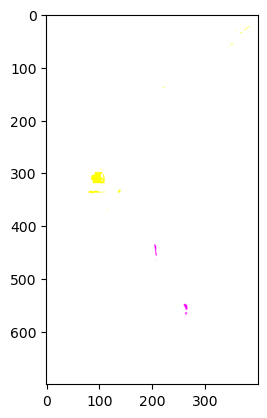

In [163]:
images_tensor = torch.FloatTensor(np.array(images_lr[0]))
blur = torchvision.transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.))(images_tensor)
plt.imshow(blur.T)
torchvision.utils.save_image(blur, 'test1_blur.png')

In [ ]:
class Sobel(nn.Module):
    def __init__(self):
        super().__init__()
        self.filter = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=0, bias=False)

        Gx = torch.tensor([[2.0, 0.0, -2.0], [4.0, 0.0, -4.0], [2.0, 0.0, -2.0]])
        Gy = torch.tensor([[2.0, 4.0, 2.0], [0.0, 0.0, 0.0], [-2.0, -4.0, -2.0]])
        G = torch.cat([Gx.unsqueeze(0), Gy.unsqueeze(0)], 0)
        G = G.unsqueeze(1)
        self.filter.weight = nn.Parameter(G, requires_grad=True)

    def forward(self, img):
        x = self.filter(img)
        x = torch.mul(x, x)
        x = torch.sum(x, dim=1, keepdim=True)
        x = torch.sqrt(x)
        return x
    
def loss_sobel(y_pred, y_true):
    torch_sobel = Sobel()
    grayscale = torchvision.transforms.Grayscale()(y_pred)
    out = torch.linalg.norm(torch_sobel(grayscale))
    print(out)
    return 1/out    

In [262]:
ignite.============

[tensor([[[[127, 145, 155,  ...,  50,  52,  53],
          [126, 141, 148,  ...,  55,  56,  57],
          [129, 141, 146,  ...,  69,  72,  75],
          ...,
          [242, 245, 240,  ...,  63,  62,  60],
          [245, 242, 236,  ...,  62,  62,  60],
          [240, 233, 230,  ...,  62,  62,  62]],

         [[ 65,  75,  77,  ...,  39,  39,  39],
          [ 60,  69,  71,  ...,  39,  38,  36],
          [ 57,  64,  67,  ...,  43,  43,  44],
          ...,
          [140, 145, 140,  ...,  41,  40,  38],
          [143, 141, 136,  ...,  41,  40,  39],
          [136, 131, 128,  ...,  41,  41,  42]],

         [[ 37,  44,  47,  ...,  36,  37,  39],
          [ 40,  48,  49,  ...,  33,  34,  34],
          [ 42,  49,  50,  ...,  35,  37,  40],
          ...,
          [ 32,  40,  36,  ...,  36,  34,  34],
          [ 39,  38,  33,  ...,  36,  35,  33],
          [ 39,  31,  27,  ...,  37,  36,  36]]]], dtype=torch.uint8), tensor([[[[127, 145, 155,  ...,  50,  52,  53],
          [126,

In [13]:
val1=1
val2=2
a = {'key1': val1, 'key2': val2}

In [14]:
a

{'key1': 1, 'key2': 2}

In [20]:
for key in a:
    print(key, a[key])

key1 1
key2 2


In [24]:
aa = 1
str = f'str {aa}'
print(str)

str 1


In [41]:
a=True
b = False

c = 4 if b != 0 #else 0


SyntaxError: invalid syntax (2315418243.py, line 4)

In [69]:
str

'str 1'

In [70]:
del str

In [71]:
str

str

In [72]:
str(3)

'3'

In [77]:
a = torch.FloatTensor(1)

In [91]:
str(np.array(a))

'[1.]'

In [97]:
a

tensor([1.])

In [100]:
a.item()

1.0

In [101]:
type(a)

torch.Tensor

In [128]:
a = np.array([1.22, 4., 5.6])
a

array([1.22, 4.  , 5.6 ])

In [131]:
m = a.mean()
m

3.606666666666667

In [132]:
type(m)

numpy.float64

In [134]:
if type(m)==np.float64:
    print(f'{m:.4f}')

3.6067


In [137]:
trainer.history.loss

[0.7947215, 0.46908444, 0.37455115, 0.34893444]

In [147]:
print(type(trainer.history.loss[0]), trainer.history.loss[0])

<class 'numpy.float32'> 0.82929516


In [148]:
aaa = trainer.history.loss[0]
aaa

0.82929516

In [149]:
type(aaa)

numpy.float32

In [150]:
if type(aaa)==np.float32:
    print (f'{aaa:.4f}')

0.8293


In [153]:
aa = trainer.history.loss[0]
match type(aa):
    case float: print('float')
    case np.float32: print('np float32')

SyntaxError: invalid syntax (3139407047.py, line 2)

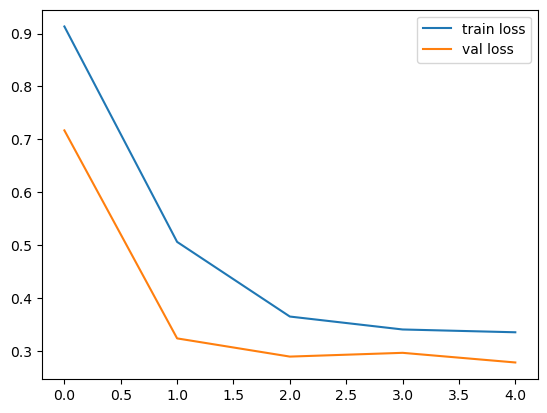

In [176]:
trainer.history.plot()

In [181]:
w = {'key1': 1, 'key2': 2, 'key3': 3}
w

{'key1': 1, 'key2': 2, 'key3': 3}

In [183]:
for item in [item for item in w if item!='key1' and item!='key3']:
    print (item)

key2
